# Designing on-target and mismatched sgRNAs for tirated CRISPRi

This code finds the basepairing region for single guide RNAs for CRISPR interference and permutes the on-target sgRNA to the mismatch patterns discussed in Mathis et al. 2020. Outputs the sgRNA sequence incorporated into a primer to clone the basepairing region into the plasmid background used in this study.

Central Inputs:
An array of E. coli gene names, which cann be modified for other organisms, but you need the whole organism fasta file which can be limiting.
Your target PAM sequence. Should not change unless you are using a different Cas9. The current Cas9 is S. pyogenes, which is in the pdCas9-bacteria plamid. Addgene-Plasmid:44249
Primer_H is the homology region on the target insert vector for the BP region of the gRNA. These BP regions can be inserted using inverse PCR. See Hawkins et al. 2015 for details on molecular biology steps.

Details: 
Searches e_coli_gene_sequences_NC_000913p3.txt for the genes of interest and extracts the fasta sequence (these are all nontemplate sequences.
For each fasta sequence, all PAM sequences are found. The PAM closest to the n-terminus is selected.
Takes reverse complement of the 20BPs downstream of the PAM sequence. This is the sgRNA sequence targeting the non-template strand.
Checks sgRNA and sgRNA reverse complement for BsaI sites. If BsaI sites are present, it will be shown in output.
BLASTs BP target gene sequence. Homology with other genes suggests sgRNA need to be redisgned.

Outputs:
CRISPRi_Design_*_.txt which contains all the relevant information about the sgRNAs.
fasta_order containing full sequences needed for sgRNA library synthesis

Written by Andrew Mathis

Updated 23 July 2020

In [1]:
import glob
from Bio.Seq import Seq
from Bio import Restriction
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
gene_path = '../inputs/20200207_selected_genes_chem.csv' # Path to selected gene information
genome_path = '../inputs/e_coli_genome_CP032667p1.txt' # Path to genome txt file for the E. coli genome
genome_fasta_path = '../inputs/e_coli_gene_sequences_NC_000913p3.txt' # Path to fasta file for the target genome
sgRNA_path = 'Gradients/' # General path for sgRNA sequences
output_path = 'Outputs/' # General path for output files
blast_path = 'Blast/' # General path to BLAST output files

PAM_NT = 'C|C|N' # Formatted PAM targeting sequence

primer_H = 'GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC' # Homology region to target plasmid
Promoter = 'TTGACAGCTAGCTCAGTCCTAGGTATAATACTAGT' # sgRNA promoter sequence
# Full sgRNA flanking sequnece
LoopTerm = 'GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTGAAG'

mut_pos1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 19] # Index for single mismatches in sgRNAs
mut_pairs = [[3, 5], [1, 7], [6, 8], [2, 9], [8, 18]] # Indices for double mismatches in sgRNAs

## Central functions for analysis

In [3]:
# Finds 3 potential sgRNAs per gene of interest. Two sgRNAs as close as possible to the 3' prime (1 to 150 BP) end
# without overlap and one at least 200 BP from 3' end. Exclused sgRNAs containing four or more consecutive thymidines
# or a GC content < 45% or > 80%. Cutoffs come from CRISPR-ERA design and Gilbert et al. 2014.
# Input -- Gene_file: Gene sequence information from E. coli genome
#          Gene_list: List of genes to target with CRISPRi
# Output -- df_parent: Potential sgRNA sequences formatted for mutagenesis
#           sgRNA_parent_blast: Potential sgRNA sequences formatted for BLAST
def pick_sg(Gene_file, Gene_list):
    sgRNA_parent = []
    sgRNA_parent_blast = []
    parent_db = {}
    for file_name in Gene_file:
        Gene = file_name.split('_')[-2]
        if Gene in Gene_list:
            with open(file_name) as FI:
                PAM = 0
                sg1_count = 0 # Number of sgRNAs close to start of gene
                sg2_count = 0 # Number of sgRNAs far from start of gene
                for i, line in enumerate(FI):
                    if sg1_count >= 2 and sg2_count >=1: # Search complete
                        break
                    if i > 0:
                        sp = line.split('\t')
                        sg = sp[1]
                        PAM_index = int(sp[3])
                        PAM_seq = sp[2]
                        if 'TTTT' not in sg: # This sequence is unfavorable for CRISPRi
                            counts = Counter(sg) # Counts frequency of each letter
                            CG_ratio = np.true_divide((counts['C'] + counts['G']), sum(counts.values()))
                            if PAM_index > PAM + 20 or PAM == 0:
                                if CG_ratio >= 0.45 and CG_ratio <= 0.80: # Optimal nucleotide ratio range
                                    if sg1_count < 2 and PAM_index <= 150: # First 2 sgRNAs must be near start
                                        Gene_ID = Gene + '_' + str(sg1_count+1) + '_' + str(PAM_index)
                                        PAM = PAM_index
                                        sg1_count += 1
                                        # List for mutagenesis
                                        parent_db[Gene_ID] = {}
                                        sgRNA_parent.append([Gene_ID, sg])

                                        # List for BLAST
                                        sgRNA_parent_blast.append('> '+ Gene_ID)
                                        sgRNA_parent_blast.append(sg)

                                        # Database
                                        parent_db[Gene_ID]['Sequence'] = sg
                                        parent_db[Gene_ID]['PAM_seq'] = PAM_seq
                                        parent_db[Gene_ID]['PAM_index'] = PAM_index

                                    elif sg2_count < 1 and PAM_index >= 200: # Third sgRNA >=200BP from start
                                        Gene_ID = Gene + '_3_' + str(PAM_index)
                                        sg2_count += 1
                                        sgRNA_parent.append([Gene_ID, sg])
                                        sgRNA_parent_blast.append('> '+ Gene_ID)
                                        sgRNA_parent_blast.append(sg)
                                        parent_db[Gene_ID] = {}

                                        # Database
                                        parent_db[Gene_ID]['Sequence'] = sg
                                        parent_db[Gene_ID]['PAM_seq'] = PAM_seq
                                        parent_db[Gene_ID]['PAM_index'] = PAM_index
    df_parent = pd.DataFrame.from_dict(parent_db).T
    
    return df_parent, sgRNA_parent_blast


# Finds 3 potential sgRNAs per gene of interest, specificially for genes where one or more sgRNAs from their initial
# list failed at the BLAST step in analysis. Two sgRNAs as close as possible to the 3' prime (1 to 150 BP) end
# without overlap and one at least 200 BP from 3' end. Exclused sgRNAs containing four or more consecutive thymidines
# or a GC content < 45% or > 80%. Cutoffs come from CRISPR-ERA design and Gilbert et al. 2014.
# Input -- Gene_file: Gene sequence information from E. coli genome
#          Fail_List: List of genes to target with CRISPRi along with information on previously failed PAM locations
# Output -- df_parent: Potential sgRNA sequences formatted for mutagenesis
#           sgRNA_parent_blast: Potential sgRNA sequences formatted for BLAST
def pick_sg_it(Gene_file, Fail_list):
    sgRNA_parent = []
    sgRNA_parent_blast = []
    parent_db = {}
    Gene_list = []
    PAM_bad = []
    for gene in Fail_list:
        sp = gene.split('_')
        Gene_list.append(sp[0])
        PAM_bad.append(sp[-1])
    for file_name in Gene_file:
        Gene = file_name.split('_')[-2]
        if Gene in Gene_list:
            PAM_B = PAM_bad[Gene_list.index(Gene)]
            with open(file_name) as FI:
                PAM = 0
                sg1_count = 0 # Number of sgRNAs close to start of gene
                sg2_count = 0 # Number of sgRNAs far from start of gene
                for i, line in enumerate(FI):
                    if sg1_count >= 2 and sg2_count >=1: # Search complete
                        break
                    if i > 0:
                        sp = line.split('\t')
                        sg = sp[1]
                        PAM_index = int(sp[3])
                        PAM_seq = sp[2]
                        if 'TTTT' not in sg: # This sequence is unfavorable for CRISPRi
                            counts=Counter(sg) # Counts frequency of each letter
                            CG_ratio = np.true_divide((counts['C'] + counts['G']), sum(counts.values()))
                            if CG_ratio >= 0.45 and CG_ratio <= 0.80: # Optimal nucleotide ratio range
                                if PAM == 0 or PAM_index > PAM + 20:
                                    if PAM_index != int(PAM_B):
                                        if sg1_count < 2 and PAM_index <= 150: # First 2 sgRNAs must be near start
                                            Gene_ID = Gene +'_'+str(sg1_count+1)+'_'+str(PAM_index)
                                            PAM = PAM_index
                                            sg1_count += 1
                                            # List for mutagenesis
                                            parent_db[Gene_ID] = {}
                                            sgRNA_parent.append([Gene_ID, sg])

                                            # List for BLAST
                                            sgRNA_parent_blast.append('> '+ Gene_ID)
                                            sgRNA_parent_blast.append(sg)

                                            # Database
                                            parent_db[Gene_ID]['Sequence'] = sg
                                            parent_db[Gene_ID]['PAM_seq'] = PAM_seq
                                            parent_db[Gene_ID]['PAM_index'] = PAM_index

                                        elif sg2_count < 1 and PAM_index >= 200: # Third sgRNA >=200BP from start
                                            Gene_ID = Gene+'_3_'+str(PAM_index)
                                            sg2_count += 1
                                            sgRNA_parent.append([Gene_ID, sg])
                                            sgRNA_parent_blast.append('> '+ Gene_ID)
                                            sgRNA_parent_blast.append(sg)
                                            parent_db[Gene_ID] = {}

                                            # Database
                                            parent_db[Gene_ID]['Sequence'] = sg
                                            parent_db[Gene_ID]['PAM_seq'] = PAM_seq
                                            parent_db[Gene_ID]['PAM_index'] = PAM_index
    df_parent = pd.DataFrame.from_dict(parent_db).T
    
    return df_parent, sgRNA_parent_blast

In [4]:
# Determines if the sgRNA homology region is unique enough to use in CRISPRi
# Input -- gene: Gene of interest for CRISPRi
#          seq: BLASTed alignment sequence
#          PAM: Potential PAM associated with the BLASTed alignment sequence
#          parent: Parent sgRNA sequence
#          MM: Mismatch number BP homology between the parent and BLASTed alignment
#          df_parent: Potential sgRNA sequences formatted for mutagenesis
# Output -- Pass/Fail: A pass indicates the sgRNA in question will likely lack off target effects. A fail excludes
#                      this sgRNA from future analysis
def blast_test(gene, seq, PAM, parent, MM, df_parent):
    # Upstream analysis already checks fully on-target sgRNAs
    if MM == 20:
        # Ensure to make sure the algorithm is extracting the correct sequences
        if df_parent['Sequence'].loc[gene] == seq and df_parent['PAM_seq'].loc[gene] == PAM:
            return 'pass'
        else:
            print('Algorithm grabbed wrong sequence or PAM for 100% 20N mismatch for: ' + gene)
            return 'fail'
    # Is there an adjacent PAM?
    if PAM[0] == 'C' and PAM[1] == 'C':
        # Does the guide have at least two mismatches? If not, off-target potential is high
        if MM >= 18:
            return 'fail'
        # Is at least one mismatch in region 1 (critical region for binding)? If not, off-target potential is high
        else:
            if seq[-8:] == parent[-8:]:
                return 'fail'
            else:
                return 'pass'
    else:
        return 'pass'

    
# Determine which sgRNAs with high sequence identity to other regions of the E. coli genome have high potential for
# off-target effects
# Input -- Blast_count: Number of BLAST hits per potential sgRNA
#          df_15: BLAST hits with at least 75% similarity to a given sgRNA
#          df_parent: Potential sgRNA sequences formatted for mutagenesis
# Output -- Gene_pass: Genes without any potential sgRNAs with a high chance of off-target effects
#           Gene_fail: Genes with at least one potential sgRNA with a high chance of off-target effects
def blast_check(Blast_count, df_15, df_parent):
    Gene_fail = []
    Gene_pass_temp = []
    for gene in Blast_count.keys():
        if gene.split('_')[0] in df_genes.index:
            if Blast_count[gene] > 1:
                starts = df_15['LocF'].loc[gene]
                stops = df_15['LocR'].loc[gene]
                MM = df_15['BP_Match'].loc[gene]
                if Counter(MM)[20] == 1:
                    for i, start in enumerate(starts):
                        stop = stops[i]
                        if start < stop:
                            bSeq = EC_Genome[start-1:stop] # Extract guide sequence
                            PAM = Seq(EC_Genome[stop:stop+3]).reverse_complement()
                            parent = df_parent['Sequence'].loc[gene]
                            test = blast_test(gene, bSeq, PAM, parent, MM[i], df_parent) # Test for off-target effects
                        else:
                            PAM = EC_Genome[stop-4:stop-1]
                            bSeq = Seq(EC_Genome[stop-1:start])
                            bSeq = bSeq.reverse_complement()
                            parent = df_parent['Sequence'].loc[gene]
                            test = blast_test(gene, bSeq, PAM, parent, MM[i], df_parent) # Test for off-target effects

                        if test == 'fail':
                            Gene_fail.append(gene)
                        else:
                            Gene_pass_temp.append(gene)
                else:
                    Gene_fail.append(gene)
    Gene_fail = list(set(Gene_fail))
    Gene_pass_temp = list(set(Gene_pass_temp))
    Gene_pass = []
    for g in Gene_pass_temp:
        if g not in Gene_fail:
            Gene_pass.append(g)
            
    return Gene_fail, Gene_pass

In [5]:
# Adds mismatches to on-target sgRNAs to create titrated CRISPRi sgRNA library and formats sgRNAs for iPCR
# Input -- i: Index of the sgRNA of interest in final list
#          sgRNA: List of all sgRNAs
#          sgRNA_name: ID for the sgRNA of interest
#          srt_I: Index of first mismatch to add to compounding mismatch guides
#          stp_I: Index of last mismatch to add to compounding mismatch guides
#          Promoter: Front-end flanking sequence for sgRNA
#          LoopTerm: Back-end flanking sequence for sgRNA
#          mut_pos1: Index for single mismatch additions
#          mut_paris: Indices for double mismatch additions
#          output_path: General path for output files
# Output -- permute: Full list of permutes sgRNAs for titrated CRISPRi
def permute_sgRNA(i, sgRNA, sgRNA_name, srt_I, stp_I, Promoter, LoopTerm, mut_pos1, mut_pairs, output_path):
    Sub = {}
    permute = {}
    sgRNA_list = list(sgRNA) # Makes each nucleotide an index in the list
    sgRNA_list_B = copy.deepcopy(sgRNA_list)
    # Homologous mismatches to mimize emergent off-target effects
    Sub['T'] = 'A'
    Sub['A'] = 'T'
    Sub['C'] = 'G'
    Sub['G'] = 'C'
    Gene_loc = sgRNA_name.split('_')[1]
   
    if Gene_loc != '2':
        oligo1 = Promoter + sgRNA + LoopTerm
        permute['C'] = oligo1
        
        for i, BP in enumerate(sgRNA_list):
            if i in mut_pos1:
                sgRNA_Wiess = list(sgRNA)
                sgRNA_Wiess[i] = Sub[BP]
                HR_Weiss = ''.join(sgRNA_Wiess)
                oligo1 = Promoter + HR_Weiss + LoopTerm
                permute['W_MM'+str(i+1)] = oligo1
                
            if i == 0:
                sgRNA_list_B = sgRNA_list
                sgRNA_list_B[i] = Sub[BP]
            if i >= srt_I and i <= stp_I:
                sgRNA_list_B[i] = Sub[BP]
                HR_bikard = ''.join(sgRNA_list_B)
                oligo2 = Promoter + HR_bikard + LoopTerm
                permute['B_MM'+str(i+1)] = oligo2
                
        for pair in mut_pairs:
            j, k = pair
            sgRNA_dub = list(sgRNA)
            sgRNA_dub[j] = Sub[sgRNA_dub[j]]
            sgRNA_dub[k] = Sub[sgRNA_dub[k]]
            HR_double = ''.join(sgRNA_dub)
            oligo3 = Promoter + HR_double + LoopTerm
            permute['D_MM' + str(j+1) + '-' + str(k+1)] = oligo3
            
    return permute

## Import data

In [6]:
# Import gene list
df_genes = pd.read_csv(gene_path, index_col=0, parse_dates=True)
Gene_list = list(df_genes.index)

# Import E. coli genome
EC_Genome = ''
with open(genome_path, 'r') as FI:
    for i, line in enumerate(FI):
        if line[0] != '>':
            EC_Genome = EC_Genome + line.rstrip('\n')

# Open the whole genome fasta file and load into memory, which likely computationally limits the size of genome
MG1655_Genome = []
with open(genome_fasta_path, 'r') as FI:
    for line in FI:
        MG1655_Genome.append(line.rstrip('\n'))

# Find all possible sgRNAs per gene on non-template strand

Searches the sequence of all genes of interest for potential sgRNA binding sites adjacent to a PAM motif. Collects and outputs all possible sgRNA locations and sequences for each gene.

In [7]:
gene_order = []
gene_sequence = []
# Extract the gene sequences associate with the genes of interest
for i, line in enumerate(MG1655_Genome):
    for gene in Gene_list:
        gene_seq_temp = []
        k = 1
        if line.find('gene=' + gene) != -1: # Identify gene of interest
            gene_order.append(gene)
            while MG1655_Genome[i + k][0] != '>': # For the entire length of one gene
                gene_seq_temp.append(MG1655_Genome[i + k])
                k = k + 1
            gene_seq_temp_flat = ''.join(gene_seq_temp)
            gene_sequence.append(gene_seq_temp_flat)

# Importing inputs, finding complement (non-coding strand), and finding BP regions next to PAM sequences
for j, Sequence in enumerate(gene_sequence):
    Sequence.upper() # Make sure all basepairs are capitalized for downstream searching
    PAM_NT = PAM_NT.upper()
    primer_H = primer_H.upper()
    gene_name = gene_order[j]
    seq_NT = Sequence

    BP_Regions = []
    PAM_Found = []
    PAM_Index = []
    # Find the BP regions downstream of PAM sequences
    for i, BP in enumerate(seq_NT[0:-20]): # Ignore last 20 BP, as a PAM there doesn't have room for a homology region
        if PAM_NT[0] != 'N' and PAM_NT[0] == BP:
            if PAM_NT[2] != 'N' and PAM_NT[2] == seq_NT[i+1]:
                if PAM_NT[4] != 'N':
                    if PAM_NT[4] == seq_NT[i+2]:
                        BP_Regions.append(seq_NT[(i+3):(i+23)])
                        PAM_Found.append(BP+seq_NT[i+1]+seq_NT[i+2])
                        PAM_Index.append(i)
                else:
                    BP_Regions.append(seq_NT[(i+3):(i+23)])
                    PAM_Found.append(BP+seq_NT[i+1]+seq_NT[i+2])
                    PAM_Index.append(i)
                    
    # Extract the sgRNA closest to the n-terminus
    output1 = []# Contains BP region design data
    output1.append('gene_name' + '\t' + 'BP_Region' + '\t' + 'PAM_Found' + '\t' + 'PAM_Index' + '\t' + 
                   'BsaI_Site' + '\t' + 'primer')
   
    
    for q, item2 in enumerate(BP_Regions):
        BP_seq = Seq(str(BP_Regions[q]))
        BP_RC = BP_seq.reverse_complement() # Find reverse complement (this is sgRNA sequence)
        # Make sure the BsaI site is not in the gRNA
        BsaI_seq = Restriction.BsaI.search(BP_seq)
        BsaI_RC = Restriction.BsaI.search(BP_RC)
        BsaI = str(BsaI_seq) + str(BsaI_RC)
        primer = BP_RC + primer_H # This is the BP region plus the homology region to make a complete primer
        output = gene_name + '\t' + BP_RC + '\t' + PAM_Found[q] + '\t' + str(PAM_Index[q] + 1) + '\t' + \
                 BsaI + '\t' + primer
        output1.append(output)
        
    F = open(sgRNA_path + 'CRISPRi_Design_' + gene_name + '_.txt', 'w') # Write all possible sgRNAs for each gene
    # Write data into files and end program.
    for item in output1:
        F.write("%s\n" % item)
    F.close()

Gene_file = glob.glob(sgRNA_path + '*.txt')

# Selected sgRNAs for each gene

Identifies three potential sgRNAs for each gene of interest by finding all PAM motifs in a gene.

In [8]:
df_parent, sgRNA_parent_blast = pick_sg(Gene_file, Gene_list)

## Output for BLAST

BLASTing all potential sgRNAs against the E. coli MG1655 genome (details in Methods) to search for potential off-target effects. Ideally, each sgRNA would have one and only one corresponding sequence on the genome. Issues arise when another sequence is (i) adjacent to a valid PAM motif and (ii) >=75% identical to the sgRNA sequence. Even in these cases, mismatches near the PAM can render potential for off-target binding to near-zero, so futher analysis parses these differences.

In [9]:
# Write for BLAST
# Initial run had too many sgRNAs for BLASt
with open(output_path + '191105_sgRNA_parent_4blast1.txt', 'w') as F:
    for item in sgRNA_parent_blast[:200]:
        F.write("%s\n" % item)
with open(output_path + '191105_sgRNA_parent_4blast2.txt', 'w') as F:
    for item in sgRNA_parent_blast[200:400]:
        F.write("%s\n" % item)
with open(output_path + '191105_sgRNA_parent_4blast3.txt', 'w') as F:
    for item in sgRNA_parent_blast[400:600]:
        F.write("%s\n" % item)
with open(output_path + '191105_sgRNA_parent.txt', 'w') as F:
    for item in sgRNA_parent_blast:
        F.write("%s\n" % item)

## Import BLAST results

Following BLASTn analysis, results are read back in and concatenated. Highly similar sequences are checked for the presence of a PAM site and other potential flags for off-target binding found by previous research. Any sgRNAs that fail these tests will be redesigned.

In [10]:
# Import BLAST data using nBLAST for E. coli MG1655 genome

df_blast1 = pd.read_csv(blast_path + 'W3UF9SMM015-191105-Alignment-HitTable1.csv', index_col=0, parse_dates=True)
df_blast2 = pd.read_csv(blast_path + 'W3UFRXZE014-191105-Alignment-HitTable2.csv', index_col=0, parse_dates=True)
df_blast3 = pd.read_csv(blast_path + 'W3UG1J8F015-191105-Alignment-HitTable3.csv', index_col=0, parse_dates=True)
# Concatenate BLAST results
df_blast = pd.concat([df_blast1, df_blast2, df_blast3])
# Remove all the organisms except MG1655 K12
df_filt = df_blast.loc[df_blast['organism'] == 'CP032667.1']
# Check how many genes have high homology to more than 1 target
df_15 = df_filt.loc[(df_filt['BP_Match'] >= 15)]
# Count the number of BLAST hits per sgRNA
Blast_count = Counter(df_15.index)

In [11]:
Gene_fail, Gene_pass = blast_check(Blast_count, df_15, df_parent)

## Redesign sgRNAs where previous sequences were rejected

Repeat this process iteratively to narrow down remaining genes

In [12]:
df_it2, sgRNA_it2_blast = pick_sg_it(Gene_file, Gene_fail)

In [13]:
with open(output_path + '191105_sgRNA_it2.txt', 'w') as F:
    for item in sgRNA_it2_blast:
        F.write("%s\n" % item)

In [14]:
# Import second run of BLAST data
df_blast_it2 = pd.read_csv(blast_path + 'W3VA6W0N014-191105-Alignment-HitTable_IT2.csv', 
                        index_col=0, parse_dates=True)
# Remove all the organisms except MG1655 K12
df_filt_it2 = df_blast_it2.loc[df_blast_it2['organism'] == 'CP032667.1']
# Check how many genes have perfect homology to more than 1 target
df_15_it2 = df_filt_it2.loc[(df_filt_it2['BP_Match'] >= 15)]
# Count the number of blast hits per sgRNA
Blast_count_it2 = Counter(df_15_it2.index)

In [15]:
Gene_fail_it2, Gene_pass_it2 = blast_check(Blast_count_it2, df_15_it2, df_it2)

## Manual BLAST and validation

Once the number of remaining genes is small enough, sgRNAs can be designed by finding PAMs and BLASTing adjacent sequences individually.

In [16]:
print(Gene_fail_it2)

['fabA_3_210', 'fabA_2_79', 'gyrB_2_67']


In [17]:
IT3 = {}
IT3['fabA_2_88'] = {}
IT3['fabA_3_226'] = {}
IT3['gyrB_2_101'] = {}

IT3['fabA_2_88']['PAM_index'] = 88
IT3['fabA_2_88']['PAM_seq'] = 'CCA'
IT3['fabA_2_88']['Sequence'] = 'ATCATCAGCATGTTCGGTGC'

IT3['fabA_3_226']['PAM_index'] = 226
IT3['fabA_3_226']['PAM_seq'] = 'CCG'
IT3['fabA_3_226']['Sequence'] = 'CCCAGGCATCCCGGCATAAC'

IT3['gyrB_2_101']['PAM_index'] = 101
IT3['gyrB_2_101']['PAM_seq'] = 'CCG'
IT3['gyrB_2_101']['Sequence'] = 'GAATACCATGTGGTGCAGAC'

df_it3 = pd.DataFrame.from_dict(IT3).T
# Took these sequences, manually BLASTed them, and analyzed results below

In [18]:
# Import BLAST results
df_blast_it3 = pd.read_csv(blast_path + 'W3VV4W6F014-191105-Alignment-HitTable_IT3.csv', index_col=0, 
                           parse_dates=True)
# Remove all the organisms except MG1655 K12
df_filt_it3 = df_blast_it3.loc[df_blast_it3['organism'] == 'CP032667.1']
# Check how many genes have perfect homology to more than 1 target
df_15_it3 = df_filt_it3.loc[(df_filt_it3['BP_Match'] >= 15)]
# Count the number of BLAST hits per sgRNA
Blast_count_it3 = Counter(df_15_it3.index)

In [19]:
Gene_fail_it3, Gene_pass_it3 = blast_check(Blast_count_it3, df_15_it3, df_it3)

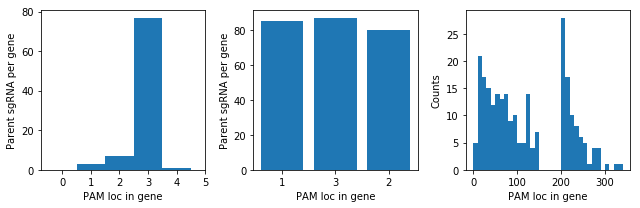

In [20]:
Filter_list = Gene_fail + Gene_fail_it2 + Gene_fail_it3
# Combine together parent sgRNAs
df_parent_filter = pd.concat([df_parent, df_it2, df_it3])
# Remove sgRNAs that failed previous iterations
df_parent_filter = df_parent_filter.drop(Filter_list)
# Remove any entirely redundant entries (redesigning one sgRNA can duplicate others)
df_parent_filter = df_parent_filter.loc[~df_parent_filter.index.duplicated(keep='first')]

# Filtering can still allow for genes to have more than 3 guides in some cases
# Count which genes have more than three guides
sg_gene = {}
sg_loc = {}
for ID in df_parent_filter.index:
    gene, rep, pam = ID.split('_')
    if gene not in sg_gene.keys():
        sg_gene[gene] = 0
        sg_gene[gene] += 1
    else:
        sg_gene[gene] += 1
    if rep not in sg_loc.keys():
        sg_loc[rep] = 0
        sg_loc[rep] += 1
    else:
        sg_loc[rep] += 1
        
plt.figure(figsize=(9, 3))
plt.subplot(131)
bins = np.arange(0, 6)
plt.hist(sg_gene.values(), bins=bins)
plt.xticks(bins+.5, bins)
plt.xlabel('PAM loc in gene')
plt.ylabel('Parent sgRNA per gene')

plt.subplot(132)
index = np.arange(len(sg_loc.values()))
plt.bar(index, sg_loc.values())
plt.xticks(index, sg_loc.keys())
plt.xlabel('PAM loc in gene')
plt.ylabel('Parent sgRNA per gene')

plt.subplot(133)
bins = np.arange(0, 350, 10)
plt.hist(list(df_parent_filter['PAM_index']), bins=bins)
plt.xlabel('PAM loc in gene')
plt.ylabel('Counts')

plt.tight_layout()

In [21]:
# One gene has more than 3 sgRNAs
for key in sg_gene.keys():
    if sg_gene[key] > 3:
        print(key + ' has more than 3 sgRNAs')
    elif sg_gene[key] == 1:
        print(key + ' has 1 sgRNAs')
    elif sg_gene[key] == 2:
        print(key + ' has 2 sgRNAs')

nadE has 1 sgRNAs
ribF has 2 sgRNAs
rpsE has 2 sgRNAs
tyrA has 2 sgRNAs
fmt has more than 3 sgRNAs
pykF has 1 sgRNAs
pykA has 2 sgRNAs
infA has 2 sgRNAs
purU has 2 sgRNAs
gpmA has 2 sgRNAs
pyrH has 1 sgRNAs


In [22]:
# Investigate fmt
for ID in df_parent_filter.index:
    gene = ID.split('_')[0]
    if gene == 'fmt':
        print(df_parent_filter.loc[ID])
        print('')

PAM_index                     104
PAM_seq                       CCC
Sequence     TCCTGCCGGTCGGTCTGGCT
Name: fmt_2_104, dtype: object

PAM_index                     222
PAM_seq                       CCA
Sequence     GCAGTTCGGCGACCAGTTGC
Name: fmt_3_222, dtype: object

PAM_index                     104
PAM_seq                       CCC
Sequence     TCCTGCCGGTCGGTCTGGCT
Name: fmt_1_104, dtype: object

PAM_index                     145
PAM_seq                       CCC
Sequence     GCCAGAACTTTAACCGGGCT
Name: fmt_2_145, dtype: object



In [23]:
# fmt_1_104 and fmt_2_104 are redundant
df_parent_final = df_parent_filter.drop('fmt_2_104')

## Making sgRNA mismatch libraries

Titrated CRISPRi relies on using partially mismatched sgRNAs stemming from a single on-target parent. This code redesigns each parent sgRNA using mismatch strategies described in the publication.

In [24]:
# Permute sgRNAs for titrated knockdown
sgRNAs = []
sgRNA_name = []
for ID in df_parent_final.index:
    sgRNAs.append(df_parent_final['Sequence'].loc[ID])
    sgRNA_name.append(ID)

permutes = {}
for i, sg in enumerate(sgRNAs):
    permutes[sgRNA_name[i]] = permute_sgRNA(i, sg, sgRNA_name[i], 1, 13, Promoter, LoopTerm, 
                                            mut_pos1, mut_pairs, output_path)

## Compile all complete sgRNA sequences

Homology region as well as flanking sequences must be included to properly synthesize an sgRNA library. This compiles all previously designed sequences, various negative control guides (both empty and randomly generated), and cell death control guides (initially targeted purE, but future analysis identified other cell death controls that were more effective).

In [25]:
# Add all "normal" sequences to fasta order
fasta_order = []
for gene in sorted(permutes.keys()):
    for MM in permutes[gene]:
        fasta_order.append('>'+gene + '_' + MM)
        fasta_order.append(permutes[gene][MM])
        
# Manually add a few more sequences
# negC none control 5 times
fasta_order.append('>negC_none_1')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_2')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_3')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_4')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_5')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_6')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_7')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_8')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_9')
fasta_order.append(Promoter + LoopTerm)
fasta_order.append('>negC_none_10')
fasta_order.append(Promoter + LoopTerm)

# purE dead control
fasta_order.append('>purE_1_9_1')
fasta_order.append(Promoter + 'CGACACGCGCCGGATTATTG' + LoopTerm)
fasta_order.append('>purE_1_9_2')
fasta_order.append(Promoter + 'CGACACGCGCCGGATTATTG' + LoopTerm)
fasta_order.append('>purE_1_9_3')
fasta_order.append(Promoter + 'CGACACGCGCCGGATTATTG' + LoopTerm)
fasta_order.append('>purE_1_9_4')
fasta_order.append(Promoter + 'CGACACGCGCCGGATTATTG' + LoopTerm)
fasta_order.append('>purE_1_9_5')
fasta_order.append(Promoter + 'CGACACGCGCCGGATTATTG' + LoopTerm)

fasta_order.append('>purE_2_19_1')
fasta_order.append(Promoter + 'ATCACGATGGCGACACGCGC' + LoopTerm)
fasta_order.append('>purE_2_19_2')
fasta_order.append(Promoter + 'ATCACGATGGCGACACGCGC' + LoopTerm)
fasta_order.append('>purE_2_19_3')
fasta_order.append(Promoter + 'ATCACGATGGCGACACGCGC' + LoopTerm)
fasta_order.append('>purE_2_19_4')
fasta_order.append(Promoter + 'ATCACGATGGCGACACGCGC' + LoopTerm)
fasta_order.append('>purE_2_19_5')
fasta_order.append(Promoter + 'ATCACGATGGCGACACGCGC' + LoopTerm)

fasta_order.append('>purE_3_47_1')
fasta_order.append(Promoter + 'CATGGTAGCCCAGTCGCTTT' + LoopTerm)
fasta_order.append('>purE_3_47_2')
fasta_order.append(Promoter + 'CATGGTAGCCCAGTCGCTTT' + LoopTerm)
fasta_order.append('>purE_3_47_3')
fasta_order.append(Promoter + 'CATGGTAGCCCAGTCGCTTT' + LoopTerm)
fasta_order.append('>purE_3_47_4')
fasta_order.append(Promoter + 'CATGGTAGCCCAGTCGCTTT' + LoopTerm)
fasta_order.append('>purE_3_47_5')
fasta_order.append(Promoter + 'CATGGTAGCCCAGTCGCTTT' + LoopTerm)

# Generate random sequences for negC
for q in np.arange(45):
    sg_rand = np.random.choice(['A', 'T', 'C', 'G'], 20)
    sg_rand = ''.join(sg_rand)
    fasta_order.append('>negC_rand_' + str(q))
    fasta_order.append(Promoter + sg_rand + LoopTerm)

with open(output_path + '20191111_sgRNA_lib.fasta', 'w') as f:
    for item in fasta_order:
        f.write("%s\n" % item)

In [26]:
# Sanity check
gene_complete = []
for row in fasta_order:
    if row[0] == '>':
        gene1 = row.split('_')[0][1:]
        gene_complete.append(gene1)
        
gene_complete = set(gene_complete)

for g1 in gene_complete:
    if g1 in df_genes.index:
        continue
    else:
        print(g1)

negC
purE
